In [1]:
from functions import BECHMARK_FUNCTIONS, FUNCTION_RANGES
import numpy as np
import time
import optuna
from optuna.samplers import RandomSampler, TPESampler
from tqdm.auto import tqdm
import pandas as pd
from ray import tune
from ray.tune.search import BasicVariantGenerator
from ray.tune.search.hyperopt import HyperOptSearch
from hyperopt import fmin, tpe, rand, hp, Trials
from itertools import product
from metagen.framework import Domain
from metagen.metaheuristics import RandomSearch, TPE
import random
from copy import deepcopy
optuna.logging.set_verbosity(optuna.logging.WARNING)

C:\Users\manjj\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
ITERATIONS_PER_RUN = 1000


def optuna_objective(function_name: str, trial):
    x = np.array([trial.suggest_float(f'x{i}', FUNCTION_RANGES[function_name][0], FUNCTION_RANGES[function_name][1]) for i in range(2)])
    return BECHMARK_FUNCTIONS[function_name](x)

def run_optuna(function_name: str, search_algorithm: str="random", seed: int=0):
    random.seed(seed)
    np.random.seed(seed)
    start_time = time.time()
    study = optuna.create_study(direction='minimize', sampler= TPESampler(seed=seed) if search_algorithm=="tpe" else RandomSampler(seed=seed))
    study.optimize(lambda trial: optuna_objective(function_name, trial), n_trials=ITERATIONS_PER_RUN//2, show_progress_bar=False)
    best_values = [t.value for t in study.trials if t.value is not None]

    end_time = time.time()

    return {"library": "optuna", "search_algorithm": search_algorithm, "function_name": function_name, 
            "best_value": study.best_value, "best_x0": study.best_params["x0"], "best_x1": study.best_params["x1"], 
            "time": end_time - start_time, "seed": seed, "best_values": deepcopy(best_values)}

def hyperopt_objective(params, function_name: str):
    x = np.array([params[f'x{i}'] for i in range(2)])
    return BECHMARK_FUNCTIONS[function_name](x)

def run_hyperopt(function_name: str, search_algorithm: str="random", seed: int=0):
    search_space = {f'x{i}': hp.uniform(f'x{i}', FUNCTION_RANGES[function_name][0], FUNCTION_RANGES[function_name][1]) for i in range(2)}

    random.seed(seed)
    np.random.seed(seed)
    
    trials = Trials()
    start_time = time.time()
    best = fmin(
        fn=lambda params: hyperopt_objective(params, function_name),
        space=search_space,
        algo=tpe.suggest if search_algorithm == "tpe" else rand.suggest,
        max_evals=ITERATIONS_PER_RUN,
        trials=trials,
        show_progressbar=False,
        rstate=np.random.default_rng(seed)
    )
    end_time = time.time()
    
    best_loss = min(trials.losses())

    
    return {"library": "hyperopt", "search_algorithm": search_algorithm, "function_name": function_name, 
            "best_value": best_loss, "best_x0": best['x0'], "best_x1": best['x1'], 
            "time": end_time - start_time, "seed": seed, "best_values": deepcopy(trials.losses())}

def metagen_objective(solution, function_name: str):
    x = np.array([solution[f'x{i}'] for i in range(2)])
    return BECHMARK_FUNCTIONS[function_name](x)

def run_metagen(function_name: str, search_algorithm: str="random", seed: int=0):
    random.seed(seed)
    np.random.seed(seed)

    domain = Domain()
    
    domain.define_real(f'x0', FUNCTION_RANGES[function_name][0], FUNCTION_RANGES[function_name][1])
    domain.define_real(f'x1', FUNCTION_RANGES[function_name][0], FUNCTION_RANGES[function_name][1])

    if search_algorithm == "tpe":
        search = TPE(domain, lambda solution: metagen_objective(solution, function_name), 
                    candidate_pool_size=ITERATIONS_PER_RUN//(ITERATIONS_PER_RUN//10), 
                    max_iterations=ITERATIONS_PER_RUN//10)
    else:
        search = RandomSearch(domain, lambda solution: metagen_objective(solution, function_name), 
                            population_size=ITERATIONS_PER_RUN//(ITERATIONS_PER_RUN//10), 
                            max_iterations=ITERATIONS_PER_RUN//10)
    
    start_time = time.time()
    best_solution = search.run()
    end_time = time.time()

    return {"library": "metagen", "search_algorithm": search_algorithm, "function_name": function_name, 
            "best_value": best_solution.get_fitness(), "best_x0": best_solution["x0"], "best_x1": best_solution["x1"], 
            "time": end_time - start_time, "seed": seed, "best_values": search.best_solution_fitnesses}

def run_multiple_seeds(run_func, function_name: str, search_algorithm: str="random", num_seeds: int=10):
    results = []
    for seed in range(num_seeds):
        result = run_func(function_name, search_algorithm, seed)
        results.append(result)
    return results

In [7]:
NUM_SEEDS = 10

all_results = []

for function_name, library, search_algorithm in tqdm(list(product(list(BECHMARK_FUNCTIONS.keys()), [run_optuna, run_hyperopt, run_metagen], ["tpe"])), desc="Overall Progress"):
    results = run_multiple_seeds(library, function_name, search_algorithm, NUM_SEEDS)
    all_results.extend(results)

df = pd.DataFrame(all_results)

Overall Progress:   0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\manjj\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [8]:
def average_arrays(arrays):
    averaged_values = np.mean(np.stack(arrays.values), axis=0)

    best_trial_evolution = np.minimum.accumulate(averaged_values)

    return best_trial_evolution

def calculate_convergence_rate(best_values):
    
    return sum([(best_values[i+1] - best_values[i])*100 / best_values[i] for i in range(len(best_values) - 1)]) / (len(best_values) -1)

averaged_arrays = df.groupby([ "function_name", "library", "search_algorithm"])["best_values"].apply(average_arrays)

convergence_rate = averaged_arrays.apply(calculate_convergence_rate)

In [9]:
#df.to_excel("results_raw_v2.xlsx")

In [10]:
grouped_metrics = df.groupby([ "function_name", "library", "search_algorithm"]).mean(numeric_only=True)
grouped_metrics["best_values"] = averaged_arrays
grouped_metrics["convergence_rate"] = convergence_rate

In [16]:
#grouped_metrics[grouped_metrics.index.get_level_values(2)=="random"].to_latex("results_random.tex")
grouped_metrics[grouped_metrics.index.get_level_values(2)=="tpe"].to_latex("results_tpe_v2.tex")

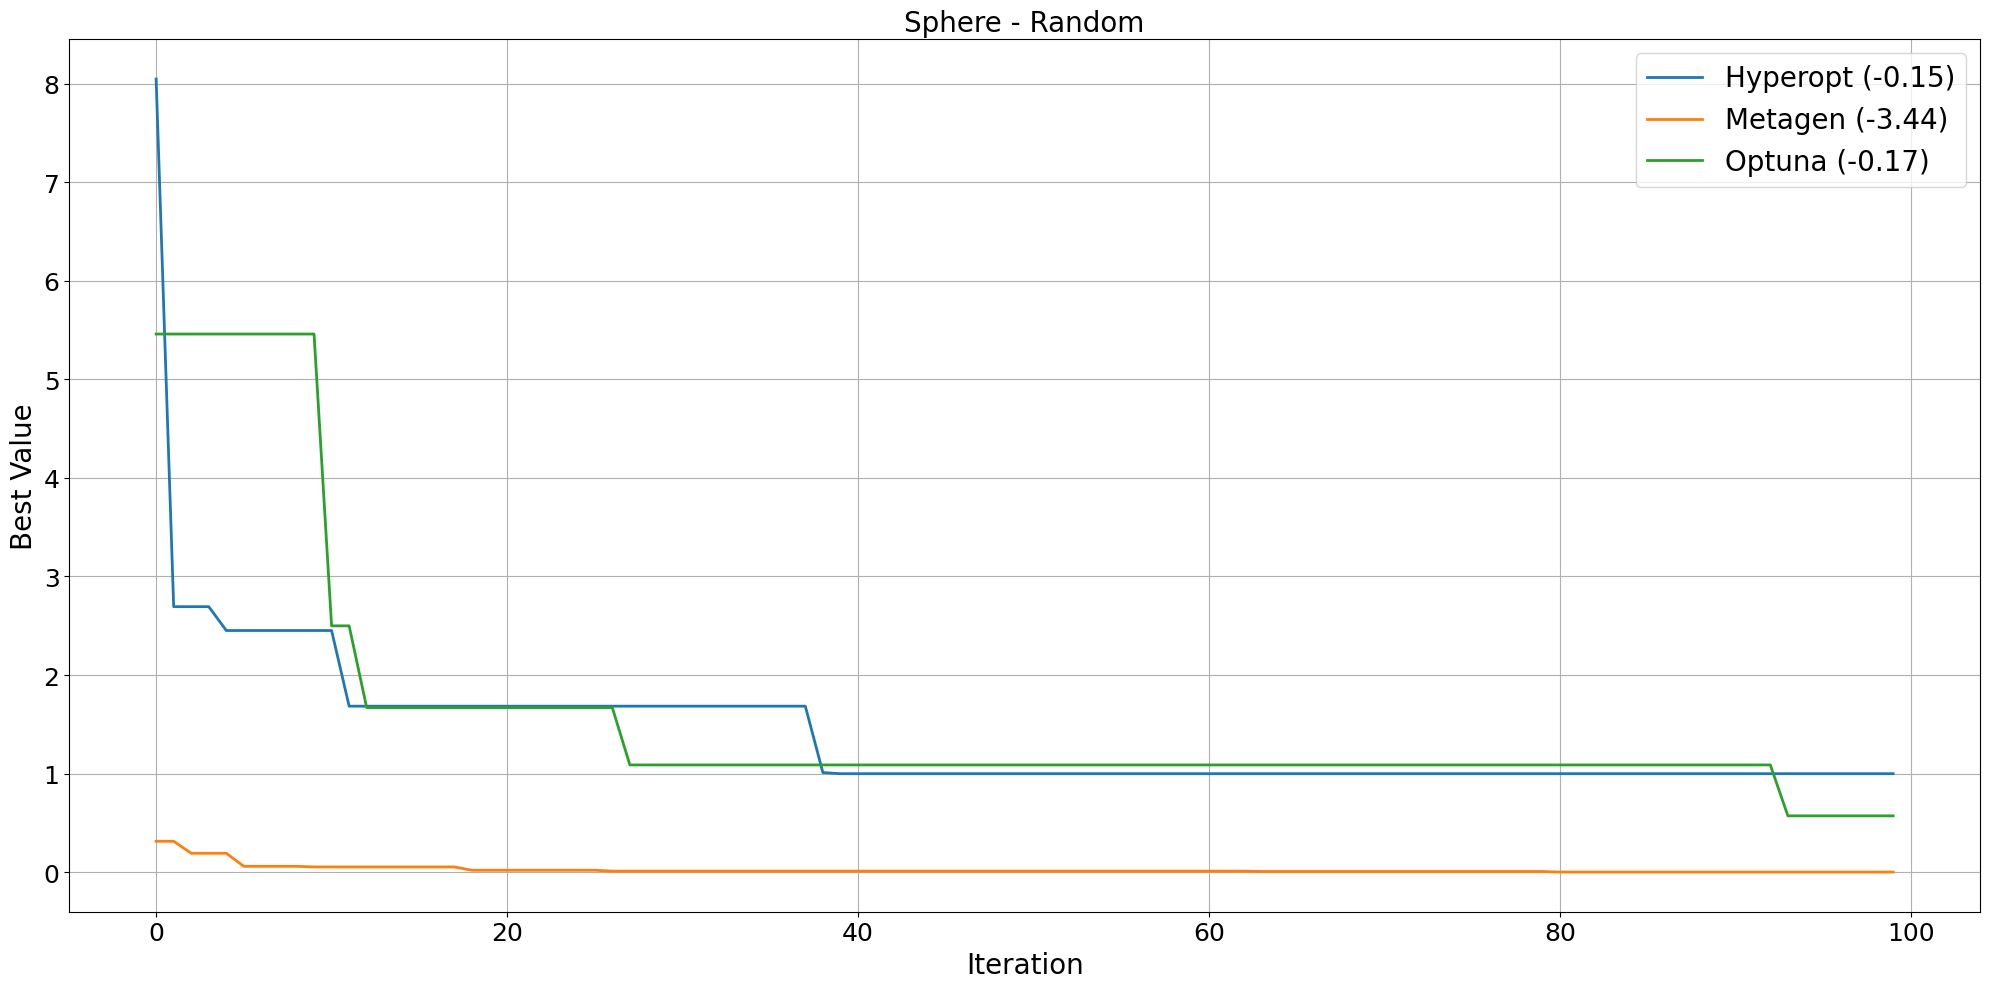

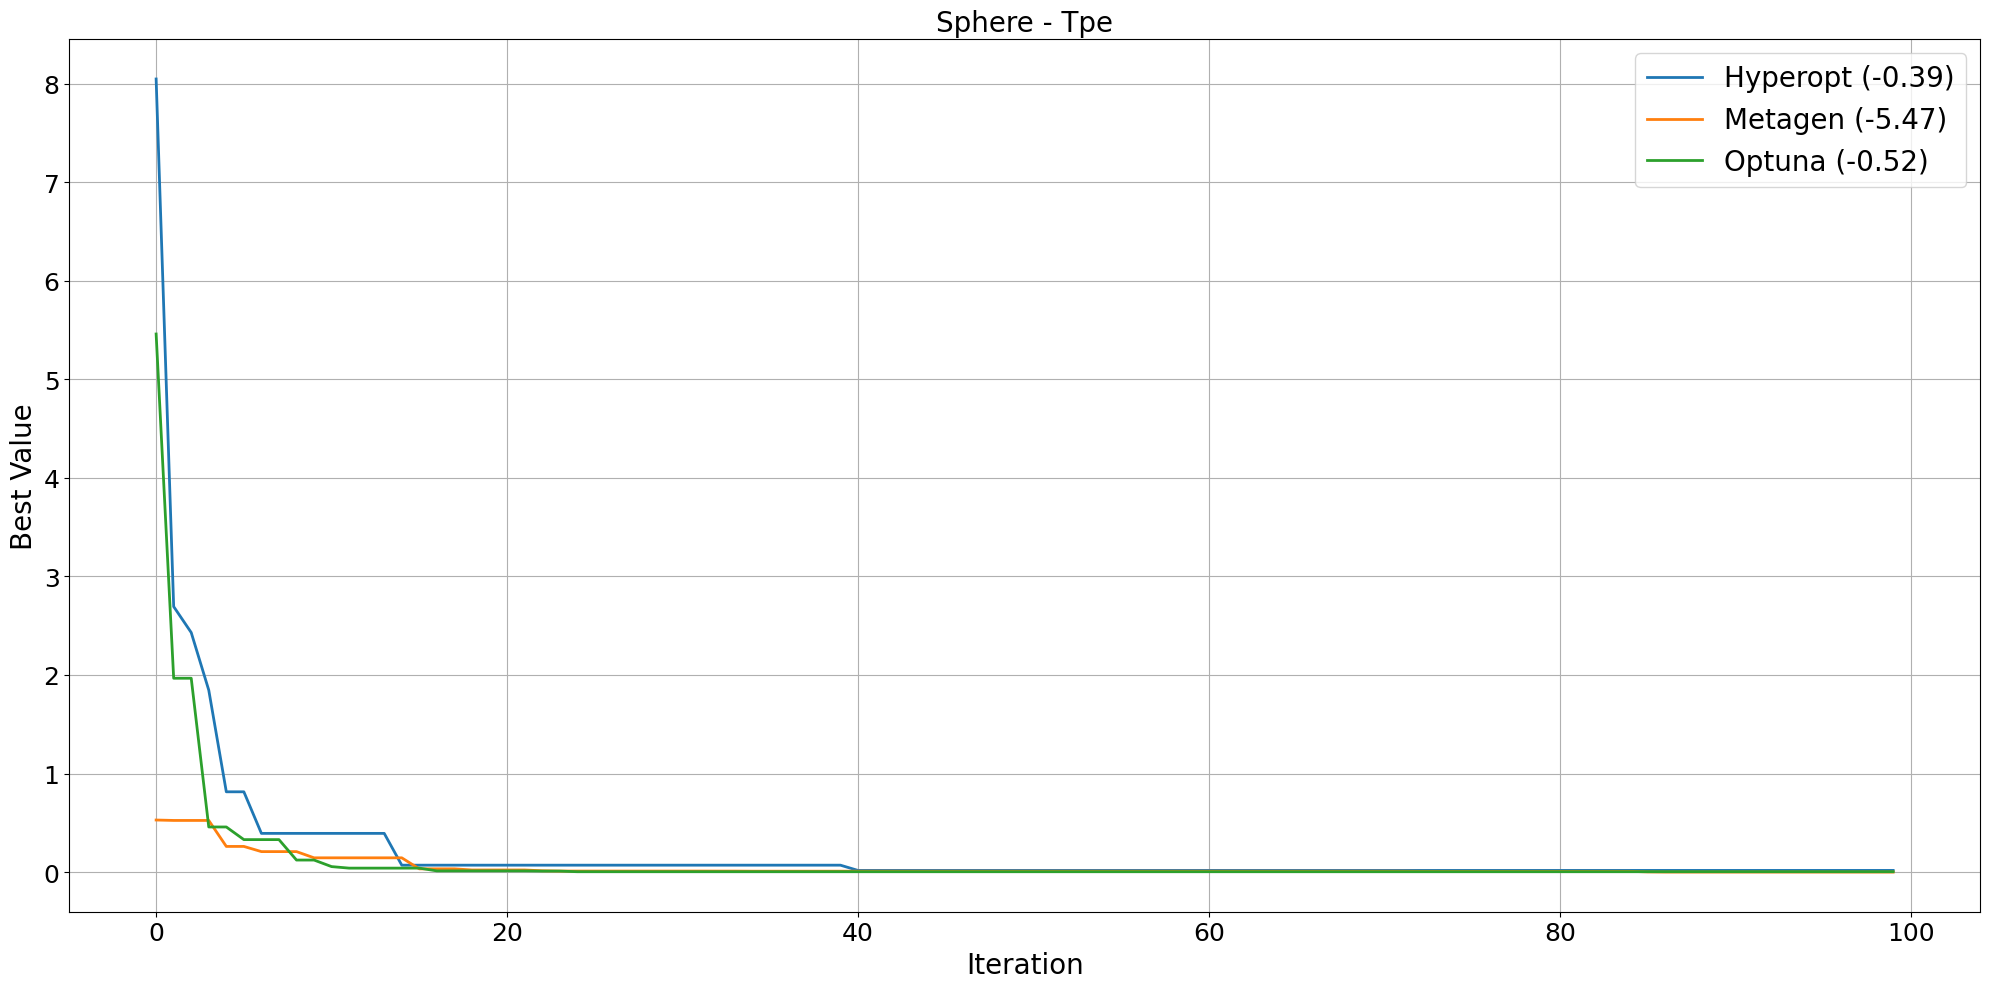

In [112]:
import matplotlib.pyplot as plt

def reescale_evolution(arr):
    n = len(arr) // 10
    
    min_values = []
    
    for i in range(n):
        chunk = arr[i*10:(i+1)*10]
        min_values.append(np.min(chunk))
    
    if len(arr) % 10 != 0:
        min_values.append(np.min(arr[n*10:]))
    
    return np.array(min_values)

for function_name, search_algorithm in product(list(BECHMARK_FUNCTIONS.keys())[:1], ["random", "tpe"]):

    filtered_metrics = grouped_metrics[(grouped_metrics.index.get_level_values(2)==search_algorithm) & (grouped_metrics.index.get_level_values(0)==function_name)]

    plt.figure(figsize=(20, 10), tight_layout=True)
    plt.title(f'{function_name.capitalize()} - {search_algorithm.capitalize()}', fontdict={'size': 20})
    for (function_name, library, search_algorithm), row in filtered_metrics.iterrows():

        best_values = row['best_values'] if library == "metagen" else reescale_evolution(row['best_values'])


        plt.plot(best_values, label=f'{library.capitalize()} ({round(row["convergence_rate"]*100, 2)})', linewidth=2)
        plt.xlabel('Iteration', fontdict={'size': 20})
        plt.xticks(fontsize=18)
        plt.ylabel('Best Value', fontdict={'size': 20})
        plt.yticks(fontsize=18)

    plt.grid()
    plt.legend(fontsize=20)
    plt.show()

In [84]:
np.roll(row['best_values']).shape

(1000,)

In [79]:
moving_average(row['best_values'], 10)

array([5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875

In [76]:
row[['best_values']].rolling(10).min()

DataError: No numeric types to aggregate

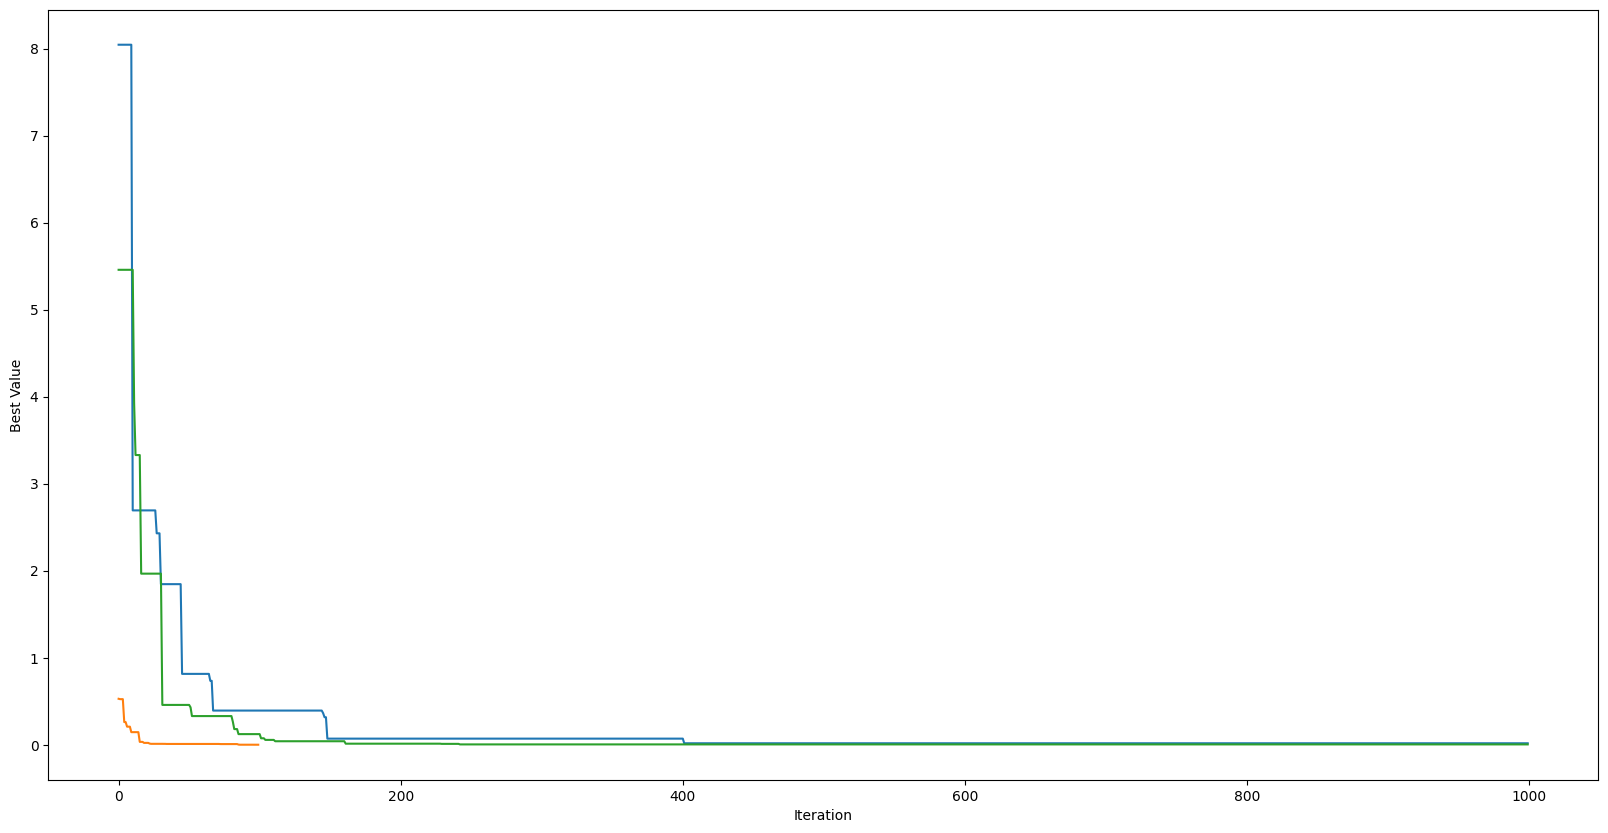

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
# Iterate over each group in the grouped_metrics dataframe
for (function_name, library, search_algorithm), row in grouped_metrics[grouped_metrics.index.get_level_values(2)=="tpe"].iterrows():
    plt.plot(row['best_values'], label=f'{library} - {search_algorithm}')
    plt.xlabel('Iteration')
    plt.ylabel('Best Value')
plt.show()